In [1]:
# Vanilla Policy-Gradient Algorithm: The fundamental Policy-based RL algorithm

import gymnasium as gym
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# Policy Neural Network, input: state, output: action distribution

class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return F.softmax(self.fc2(x), dim=1) # Softmax function, ensuring that probs sum = 1

In [3]:
# Reinforce Algorithm: Monte-Carlo Policy Gradient

class REINFORCE:
    def __init__(self, state_dim, hidden_dim, action_dim, learning_rate, gamma,
                 device):
        self.policy_net = PolicyNet(state_dim, hidden_dim,
                                    action_dim).to(device)
        self.optimizer = torch.optim.Adam(self.policy_net.parameters(), lr=learning_rate)  
        self.gamma = gamma
        self.device = device

    def take_action(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        probs = self.policy_net(state)
        action_dist = torch.distributions.Categorical(probs)
        action = action_dist.sample()
        return action.item()

    def update(self, transition_dict):
        reward_list = transition_dict['rewards']
        state_list = transition_dict['states']
        action_list = transition_dict['actions']

        G = 0
        self.optimizer.zero_grad()
        
        # Monte- Carlo estimation
        
        for i in reversed(range(len(reward_list))):
            reward = reward_list[i]
            state = torch.tensor([state_list[i]], dtype=torch.float).to(self.device)
            action = torch.tensor([action_list[i]]).view(-1, 1).to(self.device)
            
            log_prob = torch.log(self.policy_net(state).gather(1, action))  # Score Function
            G = self.gamma * G + reward
            loss = -log_prob * G  
            loss.backward()
            
        self.optimizer.step() 

In [4]:
learning_rate = 1e-3
num_episodes = 1000
hidden_dim = 128
gamma = 0.98
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

env_name = "CartPole-v1" # CartPole-v0 has been deprecated, use v1 instead
env = gym.make(env_name)
torch.manual_seed(0)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = REINFORCE(state_dim, hidden_dim, action_dim, learning_rate, gamma,
                  device)

return_list = []
for i in range(10):
    with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
        for i_episode in range(int(num_episodes / 10)):
            episode_return = 0
            transition_dict = {
                'states': [],
                'actions': [],
                'next_states': [],
                'rewards': [],
                'dones': []
            }
            state, _ = env.reset()
            done = False
            while not done:
                action = agent.take_action(state)
                next_state, reward, done, _ = env.step(action)[:4]
                transition_dict['states'].append(state)
                transition_dict['actions'].append(action)
                transition_dict['next_states'].append(next_state)
                transition_dict['rewards'].append(reward)
                transition_dict['dones'].append(done)
                state = next_state
                episode_return += reward
            return_list.append(episode_return)
            
            agent.update(transition_dict)
            
            
            if (i_episode + 1) % 10 == 0:
                pbar.set_postfix({
                    'episode':
                    '%d' % (num_episodes / 10 * i + i_episode + 1),
                    'return':
                    '%.3f' % np.mean(return_list[-10:])
                })
            pbar.update(1)

Iteration 0:   0%|          | 0/100 [00:00<?, ?it/s]<ipython-input-3-c110fb704b9c>:13: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /Users/distiller/project/pytorch/torch/csrc/utils/tensor_new.cpp:210.)
  state = torch.tensor([state], dtype=torch.float).to(self.device)
Iteration 9: 100%|██████████| 100/100 [00:05<00:00, 16.96it/s, episode=1000, return=140.000]


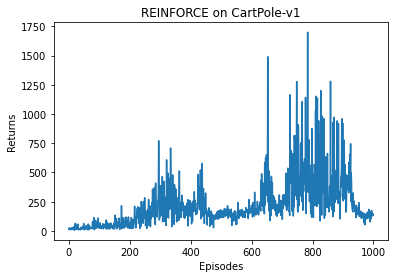

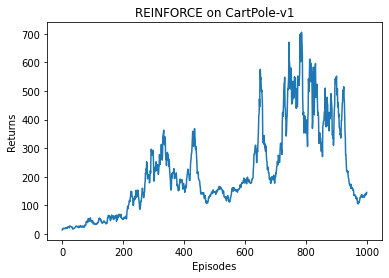

In [5]:
def moving_average(a, window_size):
    cumulative_sum = np.cumsum(np.insert(a, 0, 0)) 
    middle = (cumulative_sum[window_size:] - cumulative_sum[:-window_size]) / window_size
    r = np.arange(1, window_size-1, 2)
    begin = np.cumsum(a[:window_size-1])[::2] / r
    end = (np.cumsum(a[:-window_size:-1])[::2] / r)[::-1]
    return np.concatenate((begin, middle, end))



episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('REINFORCE on {}'.format(env_name))
plt.show()

mv_return = moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('REINFORCE on {}'.format(env_name))
plt.show()